# Code for Group Project MF 821

Chang deng, Yanbin Liu

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyfinance.ols import OLS
from sklearn.linear_model import LinearRegression
import scipy
import warnings
warnings.filterwarnings('ignore')


## 1. Data preparation and illustration
Calculate the log return of SP500 index using the “adj close” price. Draw the histogram of the log return, fit to a normal distribution, compare the tail of the fitted distribution with the empirical distribution.

In [15]:
sp500 = pd.read_csv('^GSPC.csv')[['Date','Adj Close']]
sp500.columns = ['Date','Price']
logr = np.log(sp500['Price']/sp500['Price'].shift(1))
logr.dropna(inplace = True)

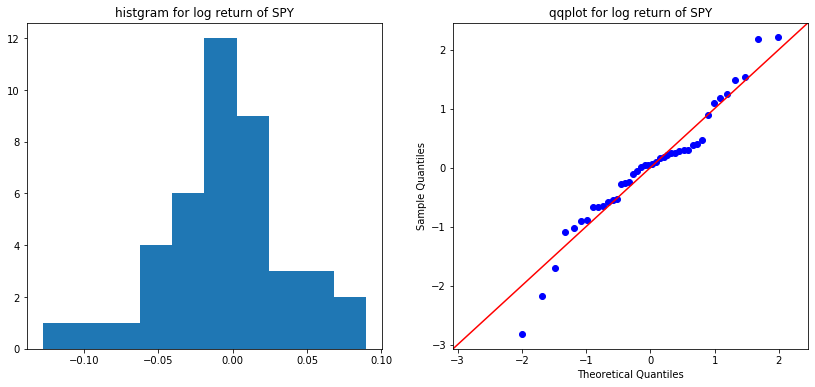

In [16]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax1.hist(logr,bins=10)
plt.title('histgram for log return of SPY')
ax2 = fig.add_subplot(122)
sm.qqplot(logr,fit=True,line='45',ax=ax2)
plt.title('qqplot for log return of SPY')
plt.show()

## 2. AR(1) model

### (a)
Split the data into a portfolio formation period and a portfolio testing period. You
can download more data during your project.

In [26]:
train_size, test_size = 21, 21
train, test = sp500.iloc[:train_size,:], sp500.iloc[train_size:train_size+test_size,:]

### (b)
In the portfolio formation period, fit the SP500 price as a linear function of time,
call this linear function $S^{ave}(t)$ and think it as the linear trend of SP500 in the
portfolio formation period.

In [98]:
train = train.reset_index()
train.rename(columns={'index': 'Time'}, inplace=True)

model = OLS(y=train.Price, x=train.Time)

train['Fitted_Price'] = model.predicted
alpha, beta = model.alpha, model.beta[0]

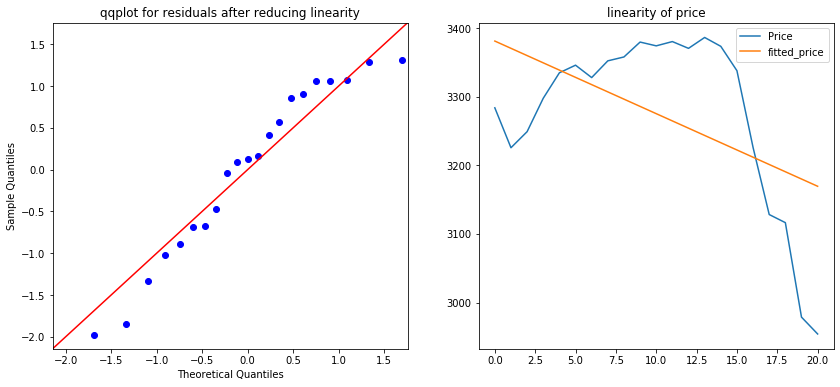

3380.916744783549

In [173]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
sm.qqplot(model.resids, fit=True, line='45',ax=ax1)
plt.title('qqplot for residuals after reducing linearity')

ax2 = fig.add_subplot(122)
plt.plot(train.Price, label='Price')
plt.plot(train.Fitted_Price,label='fitted_price')
plt.legend()
plt.title('linearity of price')
plt.show()

### (c) 
In the portfolio formation period, calculate 𝑌(𝑡) = 𝑆(𝑡) − $S^{ave}(t)$, where S(t) is
the SP500 price at time t. You can think Y(t) is the deviation from the SP500 trend. Fit a AR(1) model on ΔY(t) = Y(t)-Y(t-1) and see if there is a significant negative auto-correlation of lag 1.

In [58]:
data = train.copy()
data['Y'] = data['Price'] - data['Fitted_Price']
data['dY'] = data['Y'] - data['Y'].shift(1)
data['dY_lag'] = data['dY'].shift(1)
data.dropna(inplace = True)

In [59]:
model = OLS(y=data.dY,x=data.dY_lag,use_const=True )
beta_dy, alpha_dy = model.beta, model.alpha
pd.DataFrame([[model.alpha, model.pvalue_alpha],[model.beta, model.pvalue_beta]],columns=['value','p-value'], index=['alpha','beta'])

,value,p-value
alpha,-1.597845,0.886110
beta,0.384673,0.096906


Not a significant negative auto-correlation of lag 1

### (d) 
Extract a continuous time mean reverting model for Y using the AR(1) model for ΔY(t). Use the sample volatility of Y(t) in the portfolio formation period as the volatility parameter in your model.

For $dY_t = k(\theta-Y_{t-1})dt + \sigma dW_t$, we have $dY_t = (1-k dt)dY_{t-1}$

In [60]:
kdt = 1 - beta_dy
theta = np.mean(data.Y - beta_dy * data.Y.shift(1)) /  (kdt)
sigma = np.std(data.Y)
print('theta:',round(theta,2), 'sigma:',round(sigma,2), 'kdt:',round(kdt,2))

theta: 15.98 sigma: 106.32 kdt: 0.62


## 3. Trading strategy using ad-hoc bands

Design trading strategies by choose several ad-hoc bands using the volatility of Y(t) in the portfolio formation period. Call the lower bound Y2 and the upper bound Y3. Test these trading strategies using data in the portfolio testing period. In the testing period, you can calculate $S_{ave}(t)$ in a rolling window (for example, average of SP500 prices in the last three days). When S(t) reaches $S_{ave}(t) + Y_l$, buy SP500; when $S_{ave}(t)+Y_u$ is reached, sell SP500.

In [121]:
def ad_hoc_bands_test(data, sigma, power=0.5, win_size=3, graph=True):
    Yl = theta - power*sigma
    Yu = theta + power*sigma
    tmp = data[['Price']]
    tmp['MA'] = tmp.Price.rolling(win_size).mean().dropna()
    tmp['Buy_Singal'] = tmp['MA'] + Yl
    tmp['Sell_Singal'] = tmp['MA'] + Yu
    tmp.dropna(inplace=True)
    if graph:
        plt.title(str(power)+' times sigma ' + 'and '+ str(win_size) + ' days rolling mean' )
        plt.plot(tmp.Price,label='S(t)')
        plt.plot(tmp.Buy_Singal,label='Sl(t)')
        plt.plot(tmp.Sell_Singal,label='Su(t)')
        plt.legend()
        plt.show()
    return tmp

In [116]:
def ad_hoc_bands_train(data, sigma, power=0.5, win_size=3, graph=True):
    Yl = theta - power*sigma
    Yu = theta + power*sigma
    tmp = data[['Price']]
    tmp['MA'] = data.Fitted_Price
    tmp['Buy_Singal'] = tmp['MA'] + Yl
    tmp['Sell_Singal'] = tmp['MA'] + Yu
    tmp.dropna(inplace=True)
    if graph:
        plt.title(str(power)+' times sigma')
        plt.plot(tmp.Price,label='S(t)')
        plt.plot(tmp.Buy_Singal,label='Sl(t)')
        plt.plot(tmp.Sell_Singal,label='Su(t)')
        plt.legend()
        plt.show()
    return tmp

In [105]:
def trading_strategy(data):
    df = data.copy()
    df = df.reset_index().drop(columns=['index'])
    PnL = pd.DataFrame()
    position = 0
    Size = [0]*df.shape[0]
    Value = [1000]*df.shape[0]
    i = 0
    for i in range(0,df.shape[0]):
        if position == 0:
            if df.Price[i] <= df.Buy_Singal[i]:
                position = 1
                Size[i:] = [Value[i]/df.Price[i]]*(df.shape[0]-i)
                Value[i] = Size[i]*df.Price[i]
            else:
                if i == 1:
                    Value[i] = 1000
                else:
                    Value[i] = Value[i-1]
        else:
            if df.Price[i] >= df.Sell_Singal[i]:
                position = 0
                Value[i:] = [Size[i]*df.Price[i]]*(df.shape[0]-i)
                Size[i:] = [0]*(df.shape[0]-i)
            else:
                Value[i] = Size[i]*df.Price[i]
    if Size[-1] != 0:
        Value[-1] = list(df.Price)[-1]*Size[-1]
        Size[-1] = 0    
    PnL['Size'] = Size
    PnL['Value'] = Value
    PnL['Price'] = df.Price
    return PnL

In [113]:
test = test.reset_index()
test.rename(columns={'index': 'Time'}, inplace=True)

test['Fitted_Price'] = beta * test['Price']+ alpha

testing = test.copy()
testing['Y'] = testing['Price'] - testing['Fitted_Price']
testing.dropna(inplace = True)

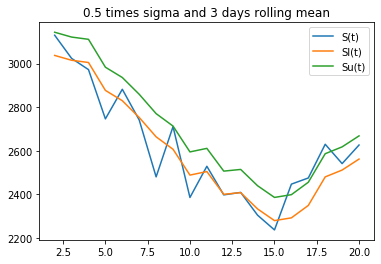

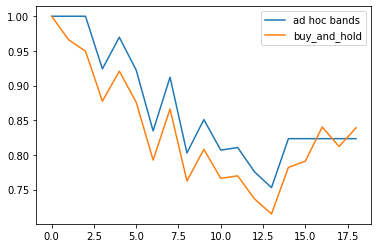

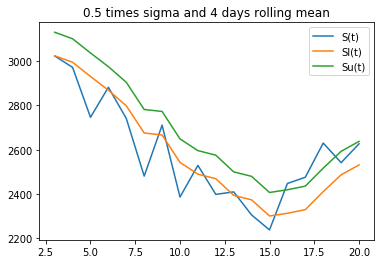

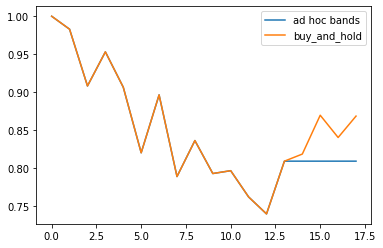

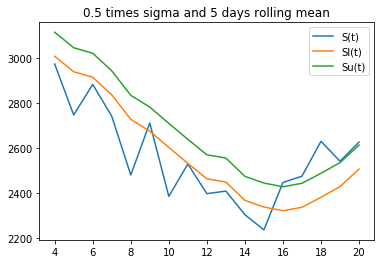

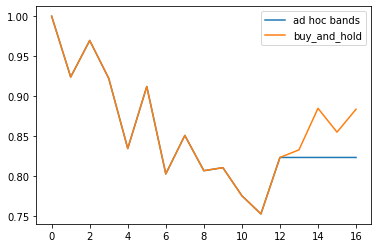

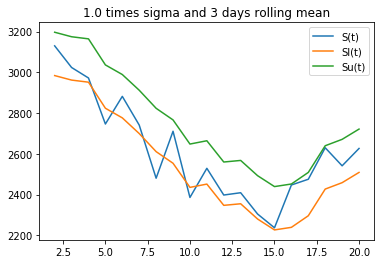

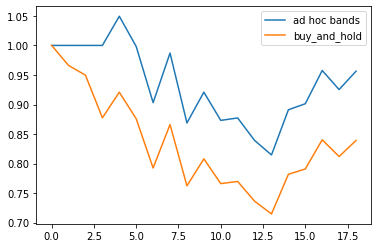

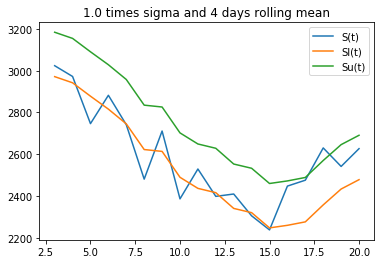

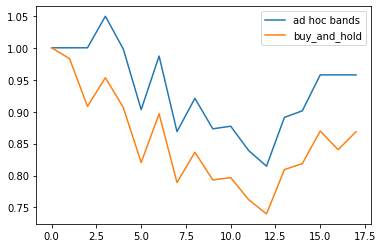

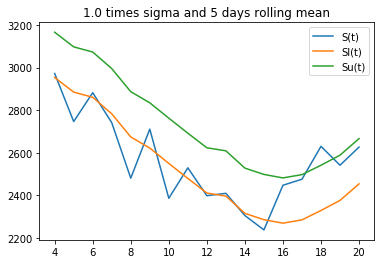

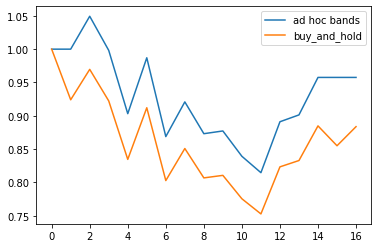

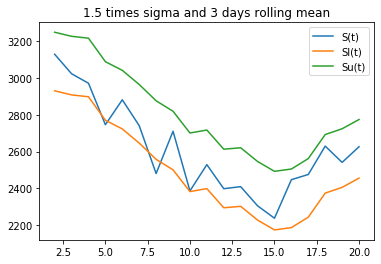

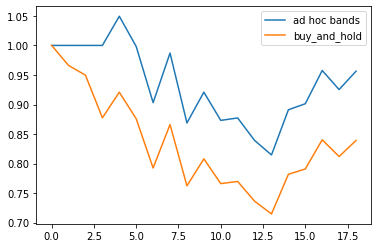

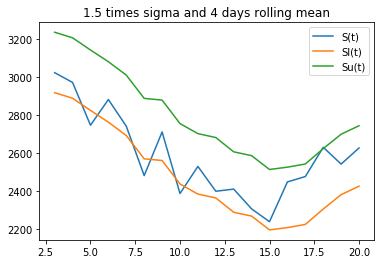

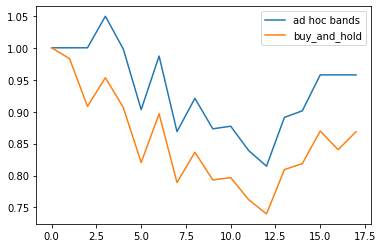

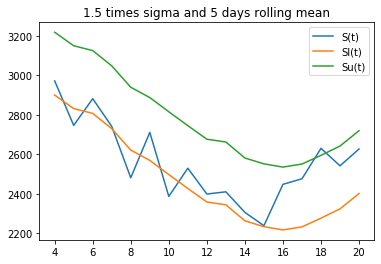

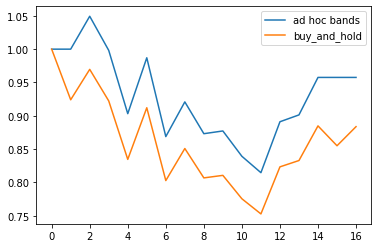

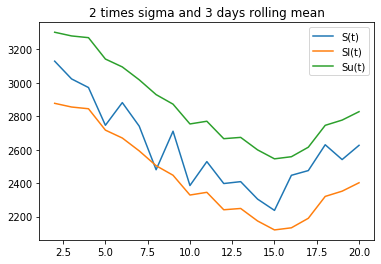

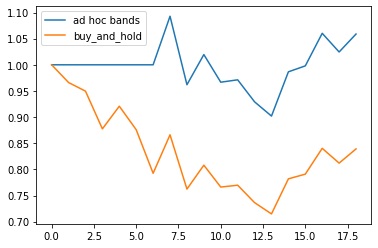

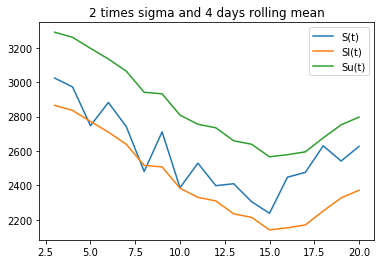

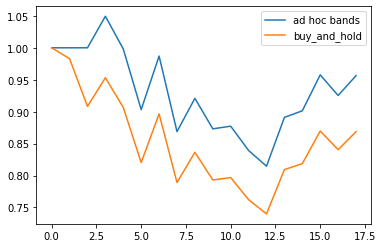

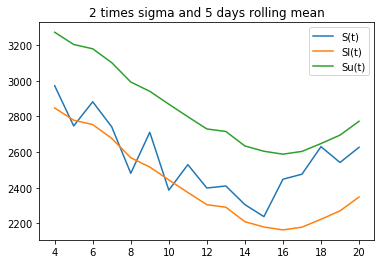

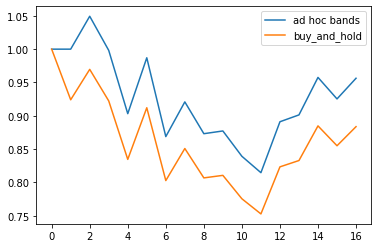

,x_sigma,win,P&L,mean,std,SR
2,0.5,3.0,-0.176640,-2.168759,0.909388,-2.384855
3,0.5,4.0,-0.190682,-2.528000,0.934855,-2.704164
4,0.5,5.0,-0.176640,-2.423907,0.963199,-2.516517
5,1.0,3.0,-0.043658,-0.182634,0.923993,-0.197657
6,1.0,4.0,-0.042413,-0.190382,0.933010,-0.204051
7,1.0,5.0,-0.042413,-0.201581,0.961719,-0.209604
8,1.5,3.0,-0.043658,-0.182634,0.923993,-0.197657
9,1.5,4.0,-0.042413,-0.190382,0.933010,-0.204051
10,1.5,5.0,-0.042413,-0.201581,0.961719,-0.209604
11,2.0,3.0,0.058860,1.071859,0.809227,1.324548


In [144]:
result = pd.DataFrame([0,0,0,0,0,0],index=['x_sigma','win','P&L','mean','std','SR'],columns=[1])
for i in [ 0.5, 1.0,  1.5, 2]:
    for j in [3,4,5]:
        test_trading_signal = ad_hoc_bands_test(test,sigma,i,j)
        pnl = trading_strategy(test_trading_signal)
        pnl['ad_hoc_bands'] = pnl['Value']/pnl['Value'].shift(1)-1
        pnl['buy_and_hold'] = pnl['Price']/pnl['Price'].shift(1)-1
        pnl = pnl.fillna(0)
        plt.plot(np.cumprod(pnl['ad_hoc_bands']+1),label='ad hoc bands')
        plt.plot(np.cumprod(pnl['buy_and_hold']+1),label='buy_and_hold')
        plt.legend()
        plt.show()
        result[result.columns[-1]+1] = [i,j,list(pnl.Value)[-1]/list(pnl.Value)[0] -1,\
                                    (pnl.ad_hoc_bands.mean())*252,pnl.ad_hoc_bands.std()*np.sqrt(252), \
               (pnl.ad_hoc_bands.mean()/pnl.ad_hoc_bands.std())*np.sqrt(252)]
result = result.iloc[:, 1:].T
result

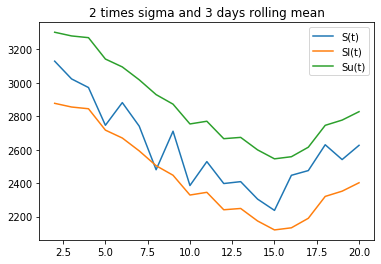

In [147]:
test_trading_signal = ad_hoc_bands_test(test,sigma,2,3)
pnl = trading_strategy(test_trading_signal)

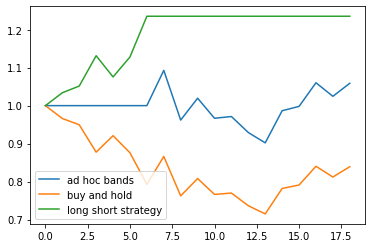

,P&L,mean,std,SR
ad_bands,0.058860,1.071859,0.809227,1.324548
buy_hold,-0.160847,-1.866334,0.969688,-1.924675
long_short,0.219707,2.938193,0.508983,5.772675


In [151]:
pnl['ad_hoc_bands'] = pnl['Value']/pnl['Value'].shift(1)-1
pnl['buy_and_hold'] = pnl['Price']/pnl['Price'].shift(1)-1
pnl['long_short'] = pnl['ad_hoc_bands']-pnl['buy_and_hold']
pnl = pnl.fillna(0)

plt.plot(np.cumprod(pnl['ad_hoc_bands']+1),label='ad hoc bands')
plt.plot(np.cumprod(pnl['buy_and_hold']+1),label='buy and hold')
plt.plot(np.cumprod(pnl['long_short']+1),label='long short strategy')
# plt.plot(data.Price/data.Price.iloc[0])
plt.legend()
plt.show()
pd.DataFrame([[list(pnl.Value)[-1]/list(pnl.Value)[0]-1,
                pnl['ad_hoc_bands'].mean()*252, pnl['ad_hoc_bands'].std()*np.sqrt(252), \
               (pnl['ad_hoc_bands'].mean()/pnl['ad_hoc_bands'].std())*np.sqrt(252)],\
             [list(pnl.Price)[-1]/list(pnl.Price)[0]-1,
                pnl['buy_and_hold'].mean()*252, pnl['buy_and_hold'].std()*np.sqrt(252), \
              (pnl['buy_and_hold'].mean()/pnl['buy_and_hold'].std())*np.sqrt(252)],\
              [list(pnl.Value)[-1]/list(pnl.Value)[0] - list(pnl.Price)[-1]/list(pnl.Price)[0],
                pnl['long_short'].mean()*252, pnl['long_short'].std()*np.sqrt(252), \
               (pnl['long_short'].mean()/pnl['long_short'].std())*np.sqrt(252)]],columns=['P&L','mean','std','SR'],index=['ad_bands','buy_hold','long_short'])

## 4. Trading strategy using optimal bands

### a) 
In the portfolio formation period, consider S(t) = Y(t) + $Y_{ave}(t)$ as a model
for the SP500 price. Here $Y_{ave}(t)$ comes from 2 (b) and Y(t) is obtained from 2 (d). Take the end of the portfolio formation period as the investment horizon. Assume the discounting factor is zero. Write down the free boundary equations for the exiting and entering problems. Both these free boundary equations for functions with respect to t and S(t).

$max\{(\partial_t +A_t) G(S_t, t), G(S_t, t) - S_t - c + H(S_t,t)\} = 0$

$max\{(\partial_t +A_t) H(S_t, t), H(S_t, t) - (S_t - c)\} = 0$

### b) 
Solve these two free boundary PDEs using finite difference methods (this is similar to American option pricing problem on a finite horizon).

In [154]:
train.shape, test.shape, alpha, beta

((21, 7), (21, 8), 3380.916744783549, -2.6441693172077865)

In [155]:
k, c = kdt, 1
Smin, Smax, M, T, N = 0,5000,1000,21,21
ht = T / N
ti = np.arange(0,T+ht,ht)
hs = (Smax - Smin) / M
Si = np.arange(Smin, Smax + hs, hs)  # j = 0,1,...,M-1

HT = Si - c

Ht = np.zeros((M,N))
Ht[:,-1] = HT[:M]


for i in range(N-1):#N-1):
    print(i, end=' ')
    if i % 10 == 0:
        print()
    di = 1 + (sigma ** 2) * (ht / (hs ** 2))
    li = -((sigma ** 2) / 2) * (ht / (hs ** 2)) + (beta + k*(theta - Si + alpha + beta*ti[-1-i])) * ht / 2 / hs
    ui = -((sigma ** 2) / 2) * (ht / (hs ** 2)) - (beta + k*(theta - Si + alpha + beta*ti[-1-i])) * ht / 2 / hs
    li_0 = li[1]
    ui_last = ui[-2]
    di = [di] * len(Si)

    B = np.diag(di[:M])
    x, y = B.nonzero()
    j_xy = ((x + 1)[0:-1], y[0:-1])
    u_xy = (x[0:-1], (y + 1)[0:-1])
    B[j_xy] = li[1:M]
    B[u_xy] = ui[:M-1]
    
    tmp = Ht[:, -1-i].copy()
    tmp[-1] +=  ui_last * (Smax -c)

    Ht[:, -1-i-1] = np.linalg.pinv(B).dot(tmp)

    Ht[:,-1-i-1] = [max(x, y) for x, y in zip(Ht[:,-1-i-1], Ht[:,-1])]

Ht = pd.DataFrame(Ht)

Ht.head(3).append(Ht.tail(3))

0 
1 2 3 4 5 6 7 8 9 10 
11 12 13 14 15 16 17 18 19 

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3303.056375,3295.843587,3288.244188,3280.181780,3271.554481,3262.221803,3251.982609,3240.537183,3227.421007,3211.888619,...,3167.830555,3133.776847,3084.720777,3010.956780,2896.515919,2715.414276,2425.701522,1959.891679,1209.438579,-1.0
1,3437.077916,3430.858148,3424.231298,3417.117378,3409.409756,3400.961442,3391.562059,3380.898222,3368.484340,3353.541228,...,3310.062472,3275.747053,3225.740879,3149.888178,3031.472267,2843.280952,2541.362568,2054.983193,1270.329683,4.0
2,3442.628315,3436.503214,3429.971168,3422.952078,3415.339173,3406.985296,3397.679863,3387.109235,3374.787495,3359.935024,...,3316.630094,3282.394947,3232.460470,3156.664222,3038.277239,2850.065496,2548.039797,2061.403095,1276.237134,9.0
997,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,...,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.0
998,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,...,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.0
999,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,...,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.0


In [156]:
k, c = kdt, 1
Smin, Smax, M, T, N = 0,5000,1000,21,21
ht = T / N
ti = np.arange(0,T+ht,ht)
hs = (Smax - Smin) / M
Si = np.arange(Smin, Smax + hs, hs)  # j = 0,1,...,M-1

GT = -2*c * np.ones(shape=Si.shape) #Si - c

Gt = np.zeros((M,N))
Gt[:,-1] = GT[:M]


for i in range(N-1):#N-1):
    print(i, end=' ')
    if i % 10 == 0:
        print()
    di = 1 + (sigma ** 2) * (ht / (hs ** 2))
    li = -((sigma ** 2) / 2) * (ht / (hs ** 2)) + (beta + k*(theta - Si + alpha + beta*ti[-1-i])) * ht / 2 / hs
    ui = -((sigma ** 2) / 2) * (ht / (hs ** 2)) - (beta + k*(theta - Si + alpha + beta*ti[-1-i])) * ht / 2 / hs

    li_0 = li[1]
    ui_last = ui[-2]
    
    
    di = [di] * len(Si)

    B = np.diag(di[:M])
    x, y = B.nonzero()
    j_xy = ((x + 1)[0:-1], y[0:-1])
    u_xy = (x[0:-1], (y + 1)[0:-1])
    B[j_xy] = li[1:M]
    B[u_xy] = ui[:M-1]

    tmp = Gt[:, -1-i].copy()
    tmp[-1] +=  ui_last * (-2*c) 
#     tmp[0] += li_0 * (-c - Si[0] - c)


    Gt[:, -1-i-1] = np.linalg.pinv(B).dot(tmp)
    Gt[:,-1-i-1] = [max(x, y) for x, y in zip(Gt[:,-1-i-1], Ht.iloc[:,-1-i-1] - Si[:-1] - c)]

Gt = pd.DataFrame(Gt)

Gt.head(3).append(Gt.tail(3))

0 
1 2 3 4 5 6 7 8 9 10 
11 12 13 14 15 16 17 18 19 

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3302.056375,3294.843587,3287.244188,3279.181780,3270.554481,3261.221803,3250.982609,3239.537183,3226.421007,3210.888619,...,3166.830555,3132.776847,3083.720777,3009.956780,2895.515919,2714.414276,2424.701522,1958.891679,1208.438579,-2.0
1,3431.077916,3424.858148,3418.231298,3411.117378,3403.409756,3394.961442,3385.562059,3374.898222,3362.484340,3347.541228,...,3304.062472,3269.747053,3219.740879,3143.888178,3025.472267,2837.280952,2535.362568,2048.983193,1264.329683,-2.0
2,3431.628315,3425.503214,3418.971168,3411.952078,3404.339173,3395.985296,3386.679863,3376.109235,3363.787495,3348.935024,...,3305.630094,3271.394947,3221.460470,3145.664222,3027.277239,2839.065496,2537.039797,2050.403095,1265.237134,-2.0
997,115.430182,109.091482,102.382029,95.284039,87.785379,79.883788,71.593215,62.952769,54.038539,44.977821,...,27.264037,19.217074,12.198165,6.550591,2.483907,-0.024913,-1.264167,-1.698728,-1.783427,-2.0
998,104.136058,98.455609,92.437495,86.065409,79.328130,72.223349,64.763407,56.983407,48.951919,40.783881,...,24.804058,17.540664,11.203452,6.103318,2.430248,0.163887,-0.956007,-1.349319,-1.429472,-2.0
999,75.406965,71.357994,67.061950,62.506736,57.683903,52.591417,47.237815,41.648086,35.871445,29.990708,...,18.470349,13.227696,8.650392,4.964284,2.307960,0.667826,-0.143509,-0.429342,-0.491907,-2.0


### c) 
Find the optimal entering boundary $S_lt)$ and the optimal exiting boundary $S_u(t)$. Since we work with a finite horizon problem, both boundaries are time dependent. Using these two boundaries, we can calculate boundaries for Y(t) via $Y_l(t) = S_l(t) - S_{ave}(t)$ and $Y_u(t) = S_u(t) - S_{ave}(t)$.

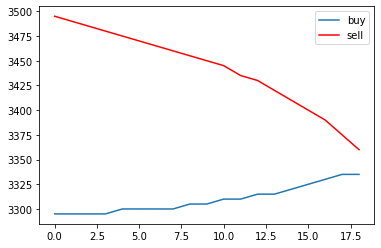

In [157]:
x_h = []
for i in Ht.columns[:-2]:
    x_h.append(Ht[i][Ht[i] != Si[:-1]-c].index[-1])
    
x_g = []
for i in Gt.columns[:-2]:
    x_g.append(Gt[i][Gt[i] == Ht[i]-Si[:-1]-c].index[-1])

plt.plot(Si[x_g], label='buy')
plt.plot(Si[x_h],color='red', label='sell')
plt.legend()
plt.show()

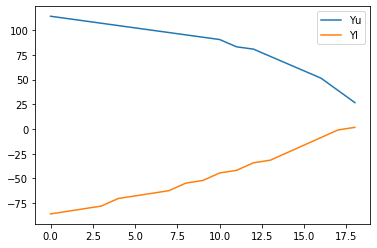

In [158]:
Su = Si[x_h]
Sl = Si[x_g]
Save = [alpha + beta*ti for ti in range(len(sp500))][:train_size-2]
Yu = Su - Save
Yl = Sl - Save
pp = test['Price']
Smean = np.array(pp.rolling(3).mean().dropna())
sell = Smean[:] + Yu[:]
buy = Smean[:] + Yl[:]
plt.plot(Yu, label='Yu')
plt.plot(Yl, label='Yl')
plt.legend()
plt.show()

### d)
In the portfolio testing period, calculate $S_{ave}(t)$ in a rolling window as in #3. When S(t) reaches $Y_l(t) + S_{ave}(t)$ buy SP500 and when S(t) reaches $Y_u(t) +
S_{ave}(t)$ sell SP500. Form a long-short strategy like #3, what is the performance of this strategy? P&L is calculated by the end of the portfolio testing period.

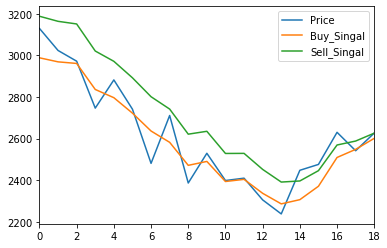

In [159]:
trading_strategy_0 = pd.DataFrame([np.array(pp)[2:],buy,sell], \
                                  index=['Price','Buy_Singal','Sell_Singal']).T
trading_strategy_0.plot()
plt.show()

In [160]:
pnl0 = trading_strategy(trading_strategy_0)

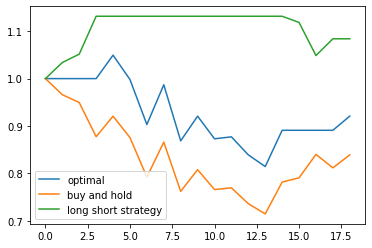

,P&L,mean,std,SR
ad_bands,0.058860,1.071859,0.809227,1.324548
buy_hold,-0.160847,-1.866334,0.969688,-1.924675
long_short,0.219707,2.938193,0.508983,5.772675


In [162]:
pnl0['optimal'] = pnl0['Value']/pnl0['Value'].shift(1)-1
pnl0['buy_and_hold'] = pnl0['Price']/pnl0['Price'].shift(1)-1
pnl0['long_short'] = pnl0['optimal']-pnl0['buy_and_hold']
pnl0 = pnl0.fillna(0)

plt.plot(np.cumprod(pnl0['optimal']+1),label='optimal')
plt.plot(np.cumprod(pnl0['buy_and_hold']+1),label='buy and hold')
plt.plot(np.cumprod(pnl0['long_short']+1),label='long short strategy')
plt.legend()
plt.show()

pd.DataFrame([[list(pnl.Value)[-1]/list(pnl.Value)[0]-1,
                pnl['ad_hoc_bands'].mean()*252, pnl['ad_hoc_bands'].std()*np.sqrt(252), \
               (pnl['ad_hoc_bands'].mean()/pnl['ad_hoc_bands'].std())*np.sqrt(252)],\
             [list(pnl.Price)[-1]/list(pnl.Price)[0]-1,
                pnl['buy_and_hold'].mean()*252, pnl['buy_and_hold'].std()*np.sqrt(252), \
              (pnl['buy_and_hold'].mean()/pnl['buy_and_hold'].std())*np.sqrt(252)],\
              [list(pnl.Value)[-1]/list(pnl.Value)[0] - list(pnl.Price)[-1]/list(pnl.Price)[0],
                pnl['long_short'].mean()*252, pnl['long_short'].std()*np.sqrt(252), \
               (pnl['long_short'].mean()/pnl['long_short'].std())*np.sqrt(252)]],columns=['P&L','mean','std','SR'],index=['ad_bands','buy_hold','long_short'])


## 5. Delay in execution
For the strategies constructed in #3 and #4, if execution (buy and sell) is delayed by 1 day (typical case when trading mutual funds), what is the performance of these long- short strategies?

### ad band

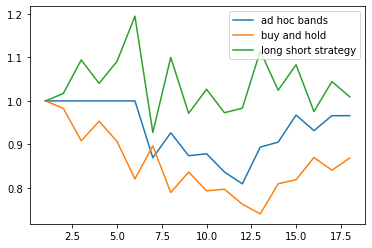

,P&L,mean,std,SR
ad_bands,-0.034011,-0.151622,0.832449,-0.182140
buy_hold,-0.131382,-1.495110,0.992272,-1.506754
long_short,0.097370,1.343488,1.577054,0.851897


In [166]:
pnl_5 = pnl.copy()
pnl_5.Size = pnl_5.Size.shift(1)
pnl_5.Size.iloc[-1] = 0
pnl_5 = pnl_5.iloc[1:,:]
pnl_5.Value = pnl_5.Value.iloc[0] + (pnl_5.Size * (pnl_5.Price.shift(-1)-pnl_5.Price) ).cumsum()
pnl_5.fillna(method='ffill',inplace=True)

pnl_5['ad_hoc_bands'] = pnl_5['Value']/pnl_5['Value'].shift(1)-1
pnl_5['buy_and_hold'] = pnl_5['Price']/pnl_5['Price'].shift(1)-1
pnl_5['long_short'] = pnl_5['ad_hoc_bands']-pnl_5['buy_and_hold']
pnl_5 = pnl_5.fillna(0)

plt.plot(np.cumprod(pnl_5['ad_hoc_bands']+1),label='ad hoc bands')
plt.plot(np.cumprod(pnl_5['buy_and_hold']+1),label='buy and hold')
plt.plot(np.cumprod(pnl_5['long_short']+1),label='long short strategy')
# plt.plot(data.Price/data.Price.iloc[0])
plt.legend()
plt.show()
pd.DataFrame([[list(pnl_5.Value)[-1]/list(pnl_5.Value)[0]-1,
                pnl_5['ad_hoc_bands'].mean()*252, pnl_5['ad_hoc_bands'].std()*np.sqrt(252), \
               (pnl_5['ad_hoc_bands'].mean()/pnl_5['ad_hoc_bands'].std())*np.sqrt(252)],\
             [list(pnl_5.Price)[-1]/list(pnl_5.Price)[0]-1,
                pnl_5['buy_and_hold'].mean()*252, pnl_5['buy_and_hold'].std()*np.sqrt(252), \
              (pnl_5['buy_and_hold'].mean()/pnl_5['buy_and_hold'].std())*np.sqrt(252)],\
              [list(pnl_5.Value)[-1]/list(pnl_5.Value)[0] - list(pnl_5.Price)[-1]/list(pnl_5.Price)[0],
                pnl_5['long_short'].mean()*252, pnl_5['long_short'].std()*np.sqrt(252), \
               (pnl_5['long_short'].mean()/pnl_5['long_short'].std())*np.sqrt(252)]],columns=['P&L','mean','std','SR'],index=['ad_bands','buy_hold','long_short'])

### Optimal

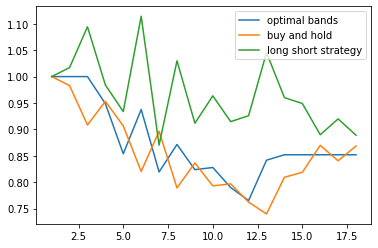

,P&L,mean,std,SR
optimal_bands,-0.148065,-1.826190,0.923517,-1.977429
buy_hold,-0.131382,-1.495110,0.992272,-1.506754
long_short,-0.016684,-0.331079,1.662826,-0.199107


In [170]:
pnl_5 = pnl0.copy()
pnl_5.Size = pnl_5.Size.shift(1)
pnl_5.Size.iloc[-1] = 0
pnl_5 = pnl_5.iloc[1:,:]
pnl_5.Value = pnl_5.Value.iloc[0] + (pnl_5.Size * (pnl_5.Price.shift(-1)-pnl_5.Price) ).cumsum()
pnl_5.fillna(method='ffill',inplace=True)

pnl_5['optimal'] = pnl_5['Value']/pnl_5['Value'].shift(1)-1
pnl_5['buy_and_hold'] = pnl_5['Price']/pnl_5['Price'].shift(1)-1
pnl_5['long_short'] = pnl_5['optimal']-pnl_5['buy_and_hold']
pnl_5 = pnl_5.fillna(0)

plt.plot(np.cumprod(pnl_5['optimal']+1),label='optimal bands')
plt.plot(np.cumprod(pnl_5['buy_and_hold']+1),label='buy and hold')
plt.plot(np.cumprod(pnl_5['long_short']+1),label='long short strategy')
# plt.plot(data.Price/data.Price.iloc[0])
plt.legend()
plt.show()
pd.DataFrame([[list(pnl_5.Value)[-1]/list(pnl_5.Value)[0]-1,
                pnl_5['optimal'].mean()*252, pnl_5['optimal'].std()*np.sqrt(252), \
               (pnl_5['optimal'].mean()/pnl_5['optimal'].std())*np.sqrt(252)],\
             [list(pnl_5.Price)[-1]/list(pnl_5.Price)[0]-1,
                pnl_5['buy_and_hold'].mean()*252, pnl_5['buy_and_hold'].std()*np.sqrt(252), \
              (pnl_5['buy_and_hold'].mean()/pnl_5['buy_and_hold'].std())*np.sqrt(252)],\
              [list(pnl_5.Value)[-1]/list(pnl_5.Value)[0] - list(pnl_5.Price)[-1]/list(pnl_5.Price)[0],
                pnl_5['long_short'].mean()*252, pnl_5['long_short'].std()*np.sqrt(252), \
               (pnl_5['long_short'].mean()/pnl_5['long_short'].std())*np.sqrt(252)]],columns=['P&L','mean','std','SR'],index=['optimal_bands','buy_hold','long_short'])